# **Data Visualization**

## Objectives

Answer Business Requirement # 1:
* Conduct a study to visually differentiate healthy cherry leaves from those with powdery mildew.

## Inputs

*  Client will input images of leaves from the following datasets : <br/>
    ** inputs/cherry-leaves_dataset/cherry-leaves/train<br/>
    ** inputs/cherry-leaves_dataset/cherry-leaves/validation <br/>
    ** inputs/cherry-leaves_dataset/cherry-leaves/test <br/>

## Outputs

* Pickle file containing image shape embeddings
* Plot illustrating the mean and variability of images per label
* Visualization to discern the contrast between images of leaves containing fungi and uninfected leaves
* Develop code that fulfills business requirement 1 and facilitates the creation of an image montage on the Streamlit dashboard.

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 



---

## Import Packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("darkgrid")
from matplotlib.image import imread

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
import os
current_dir = os.getcwd()
current_dir
os.chdir('/workspace/mildew-detection-in-cherry-leaves')
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection-in-cherry-leaves'

# Set input directories 

Set Train, Validation and Test Sets 

In [4]:
my_data_dir = 'inputs/cherry-leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

Set the output directory 

In [5]:
import os
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old Version is already available, create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old Version is already available, create a new version.


Set label names 

In [6]:
labels = os.listdir(train_path)
print('Label for the images are',labels)

Label for the images are ['healthy', 'powdery_mildew']


---

# Data Vizualization of Image Data

### Image Shape embeddings to reshape data to the desired format

Compute average images size' on Train Set

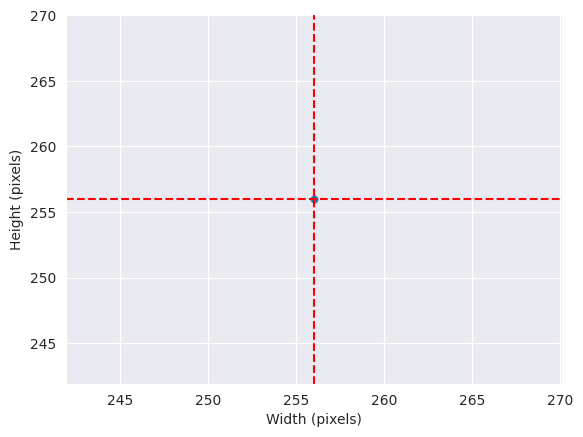

Width average: 256 
Height average: 256


In [7]:
dim1, dim2 = [], []
for label in labels:
  for image_filename in os.listdir(train_path + '/'+ label):
    img = imread(train_path + '/' + label + '/'+ image_filename)
    d1, d2, colors = img.shape
    dim1.append(d1) # image height
    dim2.append(d2) # image width

sns.set_style("darkgrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean,color='r', linestyle='--')
axes.axhline(y=dim2_mean,color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

Image size for the model is the average from all images in Trainset

In [8]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(256, 256, 3)

Save image shape embeddings

In [9]:
joblib.dump(value=image_shape ,
            filename= f"{file_path}/image_shape.pk1")
            

['outputs/v1/image_shape.pk1']

---

### Average and variability of images per label

Here, we create the function to load images in an array (tensor) to define the mean and standard deviation of pixer values in Fungal infected leaf images and non infected leaf images.

In [10]:
from tensorflow.keras.preprocessing import image

def load_image_as_array(current_dir,new_size=(50,50), n_images_per_label = 20): #Function that loads the images and their dimension
    X, y = np.array([],dtype='int'), np.array([], dtype='object')
    labels = os.listdir(current_dir)

    for label in labels:
        counter=0
        for image_filename in os.listdir(current_dir + '/' + label):
            #for n_images_per_label: we set a llimit so it doesnt take so much time
            if counter < n_images_per_label:
                img = image.load_img(current_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    image_resized = image.img_to_array(img) /255
                else:
                    image_resized = image.img_to_array(img)
                # Images are, after getting scaled and reshaped in a X array variable , in the y variable we store the label names for each image stored in the X array
                X = np.append(X, image_resized).reshape(-1, new_size[0], new_size[1], image_resized.shape[2])
                y = np.append(y, label)
                counter += 1
    # Function returns the X and Y array variables to be used when plotting 
    return X, y  



### Load the shapes of the images and their corresponding labels into an array.

In [11]:
X, y = load_image_as_array(current_dir=train_path,
                            new_size=image_shape,
                            n_images_per_label=40)
print(X.shape, y.shape)

(80, 256, 256, 3) (80,)


### Generate a plot illustrating and save the mean and variability of images for each label.

In [12]:
# Function to plot the mean and variability of images per label

def plot_mean_variability_per_labels(X, y, figsize=(12,5), save_image=False):
  """
   The pseudo code for the function is:
  * Loop in all labels
  * Subset an array for given label
  * Calculate mean and standard deviation
  * Create a figure displaying mean and variability of images
  * Save image

  """

  for label_to_display in np.unique(y):
    sns.set_style("dark")

    y = y.reshape(-1,1,1)
    boolean_mask = np.any(y==label_to_display,axis=1).reshape(-1)
    arr = X[boolean_mask]

    avg_img = np.mean(arr, axis = 0)
    std_img = np.std(arr, axis = 0)
    print(f"~~~ Label {label_to_display} ~~~")
    print(f"Image Shape: {avg_img.shape}")
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    axes[0].set_title(f"Average Image for label {label_to_display}")
    axes[0].imshow(avg_img, cmap='Greens')
    axes[1].set_title(f"Variability image for label {label_to_display}")
    axes[1].imshow(std_img, cmap='Greens')

    if save_image:
      plt.savefig(f"{file_path}/avg_var_{label_to_display}.png", bbox_inches='tight', dpi=150)
    else:
      plt.tight_layout()
      plt.show()
      print("\n")

~~~ Label healthy ~~~
Image Shape: (256, 256, 3)
~~~ Label powdery_mildew ~~~
Image Shape: (256, 256, 3)


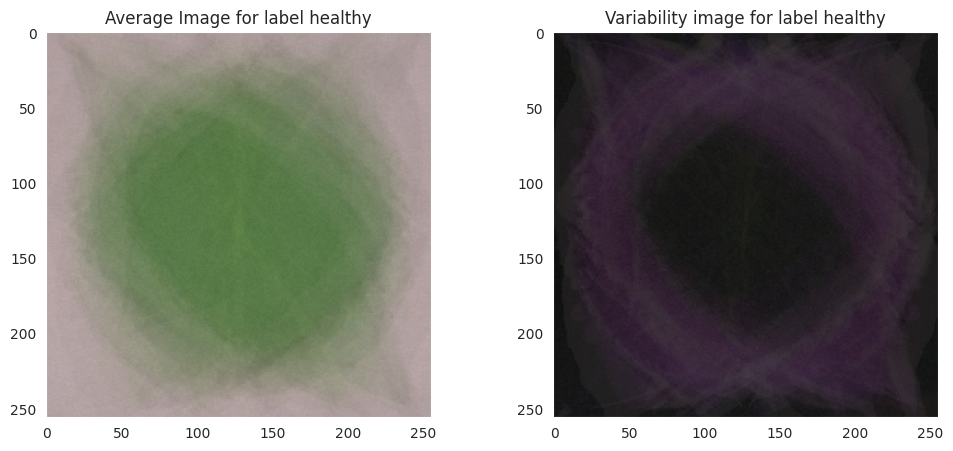

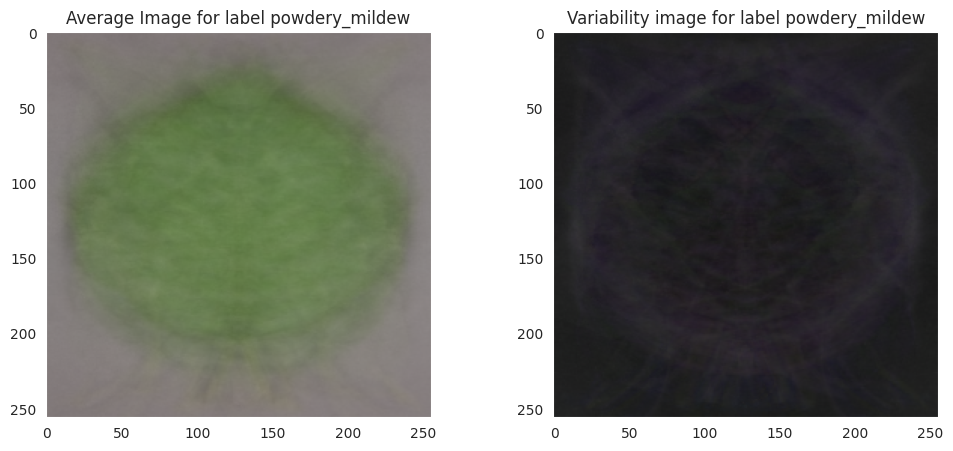

In [13]:

plot_mean_variability_per_labels(X=X, y=y, figsize=(12,5),save_image=True)

## Difference between average fungal-contained and average uninfected leaf images

Function 'dif_bet_avg_image_labels_data_as_array' will output a figure of plots for average fungal-contained and uninfected leaf images. 

In [14]:
def subset_image_label(X,y,label_to_display):
  y = y.reshape(-1,1,1)
  boolean_mask = np.any(y==label_to_display,axis=1).reshape(-1)
  df = X[boolean_mask]
  return df


def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20,5), save_image=False):
  sns.set_style("dark")

  if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
    print(f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
    return

  # calculate mean from label1
  images_label = subset_image_label(X, y, label_1)
  label1_avg = np.mean(images_label, axis = 0)

  # calculate mean from label2
  images_label = subset_image_label(X, y, label_2)
  label2_avg = np.mean(images_label, axis = 0)

  # calculate difference and plot difference, avg label1 and avg label2
  difference_mean = label1_avg - label2_avg
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
  axes[0].imshow(label1_avg, cmap='Greens')
  axes[0].set_title(f'Average {label_1}')
  axes[1].imshow(label2_avg, cmap='Greens')
  axes[1].set_title(f'Average {label_2}')
  axes[2].imshow(difference_mean, cmap='Greens')
  axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
  if save_image:
    plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
  else:
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


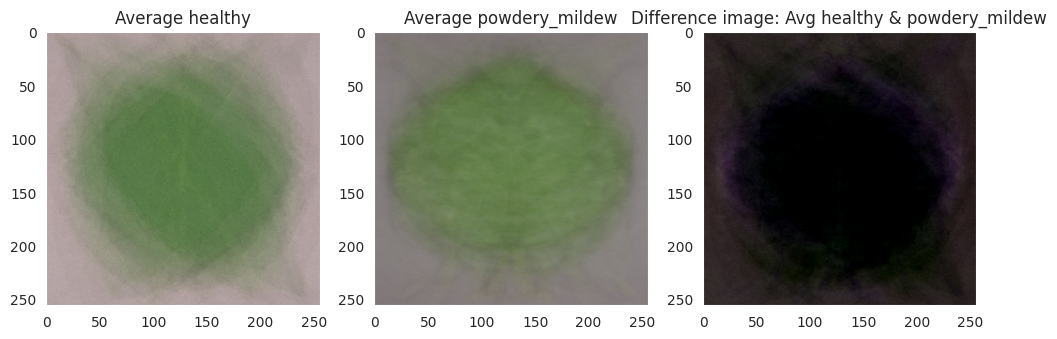

In [15]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='healthy', label_2='powdery_mildew',
                                        figsize=(12,10),
                                        save_image=True
                                        )

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* If you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [16]:
import os
try:
    # create here your folder
    # os.makedirs(name='')
except Exception as e:
    print(e)


IndentationError: expected an indented block (1114530593.py, line 5)